# %% [markdown]

 ## Pre-requisites & Auxiliary Functions

In [ ]:
# %%

# ! pip install -r requirements.txt
## imports
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import folium
import os
from datetime import time

dataset_dir = os.path.join(os.environ["BIG_DATA"], "input")

# auxiliary functions
## data processing methods
def check_missing_val(data):
    print("Checking attributes that have missing values...")
    for col in data.columns:
        if data[col].isnull().sum() != 0:
            print("{} : {}".format(col, data[col].isnull().sum()))


def check_uniqueness(data):
    print("Checking uniqueness of each attributes ...")
    for col in data.columns:
        print("{} : {} -> {}".format(col, data[col].is_unique, len(data[col].unique())))


def get_quantile(data, col_name, q_val, inter):
    return np.percentile(data[col_name], q_val, method=inter)


def iqr_test(data, col_name, inter):
    qu = get_quantile(data, 'quantity', 75, inter)
    ql = get_quantile(data, 'quantity', 25, inter)
    diff = qu - ql
    U = qu + 1.5 * diff
    L = ql - 1.5 * diff
    return U, L


def remove_outliers(data, col_name, inter):
    """filter the outliers of the numerical data

    Args:
        data (_type_): _description_
        col_name (_type_): _description_
        inter (_type_): _description_

    Returns:
        _type_: _description_
    """
    U, L = iqr_test(data, col_name, inter)
    return data[data[col_name] >= L | data[col_name] <= U]


def get_kmeans_categories(centroid, centers):
    """Returns the correct class when centroid is given

    Args:
        centroid (float): centroid assigned to given order
        centers (float): all centroids given by KNN

    Returns:
        str: specified distance range
    """
    if centroid == centers[0]:
        return 'short_range'
    elif centroid == centers[1]:
        return 'mid_range'
    else:
        return 'long_range'


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# %%

fhvhv_tripdata_2021_01 = pq.read_table(
    f'{dataset_dir}\\fhvhv_tripdata_2021-01.parquet')
fhvhv_tripdata_2021_01 = fhvhv_tripdata_2021_01.to_pandas()

In [ ]:
# %%

fhvhv_tripdata_2021_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11908468 entries, 0 to 11908467
Data columns (total 24 columns):
 #   Column                Dtype         
---  ------                -----         
 0   hvfhs_license_num     object        
 1   dispatching_base_num  object        
 2   originating_base_num  object        
 3   request_datetime      datetime64[us]
 4   on_scene_datetime     datetime64[us]
 5   pickup_datetime       datetime64[us]
 6   dropoff_datetime      datetime64[us]
 7   PULocationID          int64         
 8   DOLocationID          int64         
 9   trip_miles            float64       
 10  trip_time             int64         
 11  base_passenger_fare   float64       
 12  tolls                 float64       
 13  bcf                   float64       
 14  sales_tax             float64       
 15  congestion_surcharge  float64       
 16  airport_fee           float64       
 17  tips                  float64       
 18  driver_pay            float64       
 19

In [ ]:
# %%

# we see those flags are boolean values, can be represented as 0 and 1
fhvhv_tripdata_2021_01['shared_request_flag'] = fhvhv_tripdata_2021_01['shared_request_flag'].apply(
    lambda x: 1 if x == 'Y' else 0)
fhvhv_tripdata_2021_01['shared_match_flag'] = fhvhv_tripdata_2021_01['shared_match_flag'].apply(
    lambda x: 1 if x == 'Y' else 0)
fhvhv_tripdata_2021_01['access_a_ride_flag'] = fhvhv_tripdata_2021_01['access_a_ride_flag'].apply(
    lambda x: 1 if x == 'Y' else 0)
fhvhv_tripdata_2021_01['wav_request_flag'] = fhvhv_tripdata_2021_01['wav_request_flag'].apply(
    lambda x: 1 if x == 'Y' else 0)
fhvhv_tripdata_2021_01['wav_match_flag'] = fhvhv_tripdata_2021_01['wav_match_flag'].apply(
    lambda x: 1 if x == 'Y' else 0)

In [ ]:
# %%

nyc_weather_2021 = pd.read_csv(
    f'{dataset_dir}\\nyc 2021-01-01 to 2021-12-31.csv')
nyc_weather_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              365 non-null    object 
 1   address           365 non-null    object 
 2   resolvedAddress   365 non-null    object 
 3   datetime          365 non-null    object 
 4   temp              365 non-null    float64
 5   feelslike         365 non-null    float64
 6   dew               365 non-null    float64
 7   humidity          365 non-null    float64
 8   precip            365 non-null    float64
 9   precipprob        365 non-null    int64  
 10  preciptype        152 non-null    object 
 11  snow              365 non-null    float64
 12  snowdepth         365 non-null    float64
 13  windgust          292 non-null    float64
 14  windspeed         365 non-null    float64
 15  winddir           365 non-null    float64
 16  sealevelpressure  365 non-null    float64
 1

In [ ]:
# %%

taxi_zone_lookup = pd.read_csv(f'{dataset_dir}\\taxi_zone_lookup.csv')
taxi_zone_lookup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   LocationID    265 non-null    int64 
 1   Borough       265 non-null    object
 2   Zone          264 non-null    object
 3   service_zone  263 non-null    object
dtypes: int64(1), object(3)
memory usage: 8.4+ KB


In [ ]:
# %%

check_missing_val(fhvhv_tripdata_2021_01)

Checking attributes that have missing values...
originating_base_num : 3206079
request_datetime : 4
on_scene_datetime : 3200015
airport_fee : 11902548


In [ ]:
# %%

check_missing_val(nyc_weather_2021)

Checking attributes that have missing values...
preciptype : 213
windgust : 73
severerisk : 365


In [ ]:
# %%

check_missing_val(taxi_zone_lookup)

Checking attributes that have missing values...
Zone : 1
service_zone : 2


In [ ]:
# %%

for idx in taxi_zone_lookup.Zone.value_counts().index.to_list():
    if idx.find('Airport') != -1:
        print(idx)

JFK Airport
LaGuardia Airport
Newark Airport


In [ ]:
# %%

taxi_zone_lookup[taxi_zone_lookup.Zone.isin(
    ['Newark Airport', 'LaGuardia Airport', 'JFK Airport'])]  # airport_fee has sth to do with location ID 1,132,138

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
131,132,Queens,JFK Airport,Airports
137,138,Queens,LaGuardia Airport,Airports


In [ ]:
# %%

airport_ids = [1, 132, 138]

In [ ]:
# %%

print(len(fhvhv_tripdata_2021_01[
              fhvhv_tripdata_2021_01.PULocationID.isin(airport_ids) & fhvhv_tripdata_2021_01.DOLocationID.isin(
                  airport_ids)]))
print(len(fhvhv_tripdata_2021_01[
              fhvhv_tripdata_2021_01.PULocationID.isin(airport_ids) & ~fhvhv_tripdata_2021_01.DOLocationID.isin(
                  airport_ids)]))
print(len(fhvhv_tripdata_2021_01[
              ~fhvhv_tripdata_2021_01.PULocationID.isin(airport_ids) & fhvhv_tripdata_2021_01.DOLocationID.isin(
                  airport_ids)]))

6852
168695
190456


In [ ]:
# %%

fhvhv_tripdata_2021_01.loc[
    fhvhv_tripdata_2021_01.PULocationID.isin(airport_ids) & fhvhv_tripdata_2021_01.DOLocationID.isin(
        airport_ids), 'airport_fee'] = 6852 * [5]
fhvhv_tripdata_2021_01.loc[
    fhvhv_tripdata_2021_01.PULocationID.isin(airport_ids) & ~fhvhv_tripdata_2021_01.DOLocationID.isin(
        airport_ids), 'airport_fee'] = 168695 * [2.5]
fhvhv_tripdata_2021_01.loc[
    ~fhvhv_tripdata_2021_01.PULocationID.isin(airport_ids) & fhvhv_tripdata_2021_01.DOLocationID.isin(
        airport_ids), 'airport_fee'] = 190456 * [2.5]

In [ ]:
# %%

fhvhv_tripdata_2021_01['airport_fee'].fillna(value=0, inplace=True)
fhvhv_tripdata_2021_01.dropna(inplace=True)  # drop the other missing values

<ipython-input-15-5f5c54f77827>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fhvhv_tripdata_2021_01['airport_fee'].fillna(value=0, inplace=True)


In [ ]:
# %%

nyc_weather_2021['windgust'].fillna(-1, inplace=True)
windgust_data = nyc_weather_2021['windgust'].to_list()

<ipython-input-16-4ac8753a3c5c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nyc_weather_2021['windgust'].fillna(-1, inplace=True)


In [ ]:
# %%

# nyc_weather_2021['windgust'].fillna(method='ffill',inplace=True)
for idx, num in enumerate(windgust_data):
    if num == -1:
        if idx == 0:
            windgust_data[idx] = windgust_data[idx + 1]
        elif idx == len(windgust_data) - 1:
            windgust_data[idx] = windgust_data[idx - 1]
        else:
            if windgust_data[idx - 1] != -1 and windgust_data[idx + 1] != -1:
                windgust_data[idx] = (windgust_data[idx - 1] + windgust_data[idx + 1]) / 2
            else:
                windgust_data[idx] = windgust_data[idx - 1] if windgust_data[idx - 1] != -1 else windgust_data[idx + 1]

nyc_weather_2021['windgust'] = windgust_data

In [ ]:
# %%

nyc_weather_2021['preciptype'].fillna(value='rain', inplace=True)  # fill with mode, which is 'rain'

<ipython-input-18-91fdb87413d6>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nyc_weather_2021['preciptype'].fillna(value='rain', inplace=True)  # fill with mode, which is 'rain'


In [ ]:
# %%

nyc_weather_2021.drop(columns=['severerisk'], inplace=True)  # drop the useless column

In [ ]:
# %%

taxi_zone_lookup[taxi_zone_lookup.Zone.isnull()]

,LocationID,Borough,Zone,service_zone
264,265,Unknown,NaN,NaN


In [ ]:
# %%

taxi_zones = gpd.read_file(f'{dataset_dir}\\taxi_zones\\taxi_zones.shp')
taxi_zones.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB


In [ ]:
# %%

taxi_zones[taxi_zones.LocationID == 265]  # no data retrieved, seems we have to drop the empty data

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry


In [ ]:
# %%

taxi_zone_lookup.dropna(inplace=True)
taxi_zones.dropna(inplace=True)

In [ ]:
# %%

fhvhv_tripdata_2021_01.drop_duplicates(inplace=True)
nyc_weather_2021.drop_duplicates(inplace=True)
taxi_zone_lookup.drop_duplicates(inplace=True)
taxi_zones.drop_duplicates(inplace=True)

In [ ]:
# %%

fhvhv_tripdata_2021_01.drop_duplicates(inplace=True)
nyc_weather_2021.drop_duplicates(inplace=True)
taxi_zone_lookup.drop_duplicates(inplace=True)
taxi_zones.drop_duplicates(inplace=True)

<Axes: >

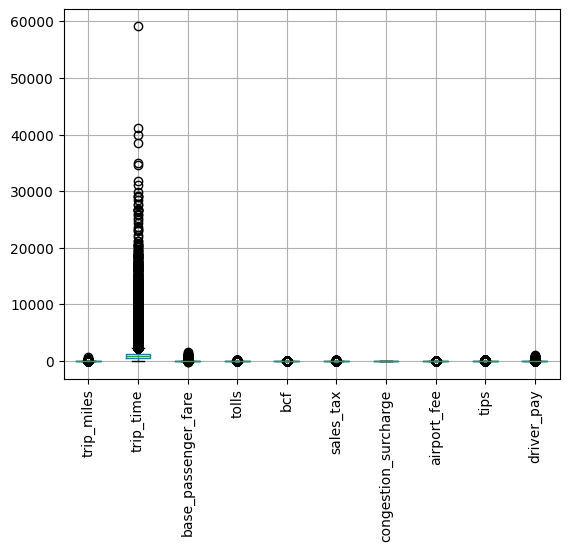

In [ ]:
# %%

# do we still need to find and filter outliers for this project? suppose all the data collected well
trip_data_outliers = fhvhv_tripdata_2021_01[['trip_miles', 'trip_time', 'base_passenger_fare', 'tolls', 'bcf',
                                             'sales_tax', 'congestion_surcharge', 'airport_fee', 'tips',
                                             'driver_pay']].boxplot(rot=90)

trip_data_outliers
# Image.open("img/trip_data_outliers.png")

In [ ]:
# %%

trip_locations = fhvhv_tripdata_2021_01[['PULocationID', 'DOLocationID']].boxplot()
# trip_locations.figure.savefig("img/trip_loc_distribution.png",bbox_inches="tight")
trip_locations
# Image.open("img/trip_loc_distribution.png")

<Axes: >

In [ ]:
# %%

## warning: takes about 20 secs
# Filter the data according to our need
# All pickup (originate) locations in Jan,2021
# All drop-off (destination) locations in Jan,2021
# now seperate the data based on day (6:00-18:00) and night (18:00-6:00)
day_start = time(6, 0, 0)
day_end = time(18, 0, 0)
# locations in day time
tripdata_2021_01_src_day = fhvhv_tripdata_2021_01.loc[
    (fhvhv_tripdata_2021_01['pickup_datetime'].dt.time >= day_start) & (
                fhvhv_tripdata_2021_01['pickup_datetime'].dt.time <= day_end)]
tripdata_2021_01_dst_day = fhvhv_tripdata_2021_01.loc[
    (fhvhv_tripdata_2021_01['dropoff_datetime'].dt.time >= day_start) & (
                fhvhv_tripdata_2021_01['dropoff_datetime'].dt.time <= day_end)]
# locations in night
tripdata_2021_01_src_night = fhvhv_tripdata_2021_01.loc[
    (fhvhv_tripdata_2021_01['pickup_datetime'].dt.time < day_start) | (
                fhvhv_tripdata_2021_01['pickup_datetime'].dt.time > day_end)]
tripdata_2021_01_dst_night = fhvhv_tripdata_2021_01.loc[
    (fhvhv_tripdata_2021_01['dropoff_datetime'].dt.time < day_start) | (
                fhvhv_tripdata_2021_01['dropoff_datetime'].dt.time > day_end)]

# %% [markdown]

 ### Geospatial Analysis

In [ ]:
# %%

taxi_zones = taxi_zones.to_crs(2263)
taxi_zones['centroid'] = taxi_zones.centroid

In [ ]:
# %%

taxi_zones = taxi_zones.to_crs(epsg=4326)  # project the centroids' locations to another coordinate system
taxi_zones['centroid'] = taxi_zones['centroid'].to_crs(epsg=4326)
taxi_zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,centroid
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.695, -74.18449 40.6951,...",POINT (-74.174 40.69183)
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",POINT (-73.8313 40.61675)
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",POINT (-73.84742 40.86447)
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",POINT (-73.97697 40.72375)
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",POINT (-74.18848 40.55266)


In [ ]:
# %%

m1 = folium.Map(location=[40.70, -73.94], zoom_start=12, tiles="Stamen Toner")

# add centroid marker to each taxi zones
latitudes = []
longitudes = []
# markers_group = folium.FeatureGroup(name='Taxi Zones Centroids')
for _, r in taxi_zones.iterrows():
    lat = r['centroid'].y
    latitudes.append(lat)
    lon = r['centroid'].x
    longitudes.append(lon)
    folium.Marker(location=[lat, lon],
                  popup='LocationID:{}<br>Zone:{}<br>Borough:{}'.format(r['LocationID'], r['zone'], r['borough']),
                  icon=folium.Icon(icon='info-sign')).add_to(m1)

# project geometries on the map to locate precise regions of taxi zones
for _, r in taxi_zones.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.0001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'fillColor': 'green'})
    folium.Popup(r['zone']).add_to(geo_j)
    geo_j.add_to(m1)

# markers_group.add_to(m)
taxi_zones['c_latitude'] = latitudes
taxi_zones['c_longitude'] = longitudes
# m1.save('maps/taxi_zones.html') # save as html
m1

ValueError: Custom tiles must have an attribution.